In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 150
import torch
import zuko
import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml
import corner
from pathlib import Path
import shutil

from torch_june import Runner

In [2]:
device = "cpu"

param_names = ["school", "company"]
true_values = [2, 1.5]#, 1.3]#, 1.5, 1.0]

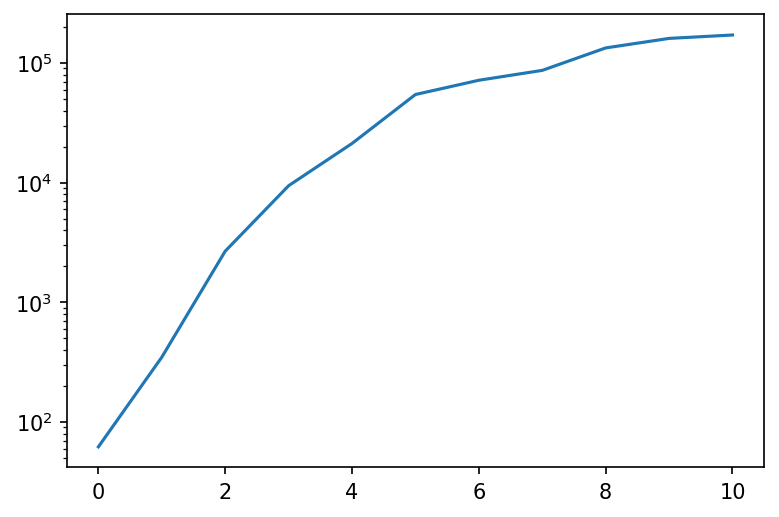

In [3]:
def load_runner():
    params = yaml.safe_load(open("../../bayesian_gradabm/configs/june.yaml"))
    params["system"]["device"] = device
    r = Runner.from_parameters(params)
    return r
runner = load_runner()

def generate_data():
    data = pd.read_csv("../../bayesian_gradabm/results/june/results.csv")
    ret = {}
    for col in data.columns:
        if col == "date":
            ret[col] = data[col]
        else:
            ret[col] = torch.tensor(data[col].values.astype(float), device=device, dtype=torch.float)
    return ret
data = generate_data()
plt.plot(data["cases_per_timestep"].cpu())
plt.yscale("log")

In [4]:
def plot_posterior(flow, it):
    flow_c = flow(data["cases_per_timestep"])
    samples = flow_c.sample((10000,))
    samples = samples.cpu().detach().numpy()
    samples = np.where(~np.isnan(samples), samples, 0)
    samples = np.where(~np.isinf(samples), samples, 0)
    samples = np.where(np.abs(samples) < 5, samples, 0)
    f = corner.corner(samples, labels = param_names, 
                      smooth=2, 
                      truths=true_values,
                      show_titles=True,
                      bins=30,
                      range = [(-4,4) for i in range(len(true_values))])
    f.savefig(f"./flow_results/posteriors/posterior_{it:03d}.png", dpi=150, facecolor='white')
    return

def plot_prediction(cases_mean, cases_std, data, it):
    dates = data["date"]
    f, ax = plt.subplots()
    cases_mean = cases_mean.cpu()
    cases_std = cases_std.cpu()
    ax.plot(dates, data["cases_per_timestep"].cpu(), color = "black", label = "data")
    ax.plot(dates, cases_mean, color = "C0", label = "prediction")
    ax.fill_between(dates, cases_mean - cases_std, cases_mean + cases_std, color = "C0", alpha=0.5, linewidth=0)
    ax.set_yscale("log")
    ax.legend()
    ax.set_ylabel("Cases")
    f.autofmt_xdate()
    f.savefig(f"./flow_results/fits/fit_{it:03d}.png", dpi=150, facecolor='white')
    return

In [5]:

# Neural spline flow (NSF) with 3 transformations
flow = zuko.flows.NSF(2, len(data["cases_per_timestep"]), transforms=3, hidden_features=[128] * 3)
flow = flow.to(device)

In [6]:
def run_for_params(params):
    params = torch.clip(params, min=-5, max=5)
    for i, name in enumerate(param_names):
        runner.model.infection_networks.networks[name].log_beta = params[i]
    results, _ = runner()
    return results

In [7]:
def get_forecast_score(flow, x, n_samples=5):
    loss = 0
    cases = None
    samples = flow(x).rsample((n_samples,))
    for sample in samples:
        if torch.isnan(params).any():
            continue
        results = run_for_params(sample)
        for key in results:
            if key == "cases_per_timestep": #"cases_by_age" in key:
                prediction = results[key]
                cases_data = data[key]
                loss_i = loss_fn(prediction, cases_data)
        #loss_i.backward()
        loss += loss_i / n_samples
    return loss

  0%|                                                                                                                                                              | 0/250 [00:00<?, ?it/s]/Users/arnull/miniconda3/envs/torch/lib/python3.10/site-packages/corner/core.py:775: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  return ax.set_ylim(new_ylim)
/Users/arnull/miniconda3/envs/torch/lib/python3.10/site-packages/corner/core.py:583: RuntimeWarning: invalid value encountered in true_divide
  sm /= sm[-1]
  0%|                                                                                                                                                            | 0/250 [1:00:05<?, ?it/s]


KeyboardInterrupt: 

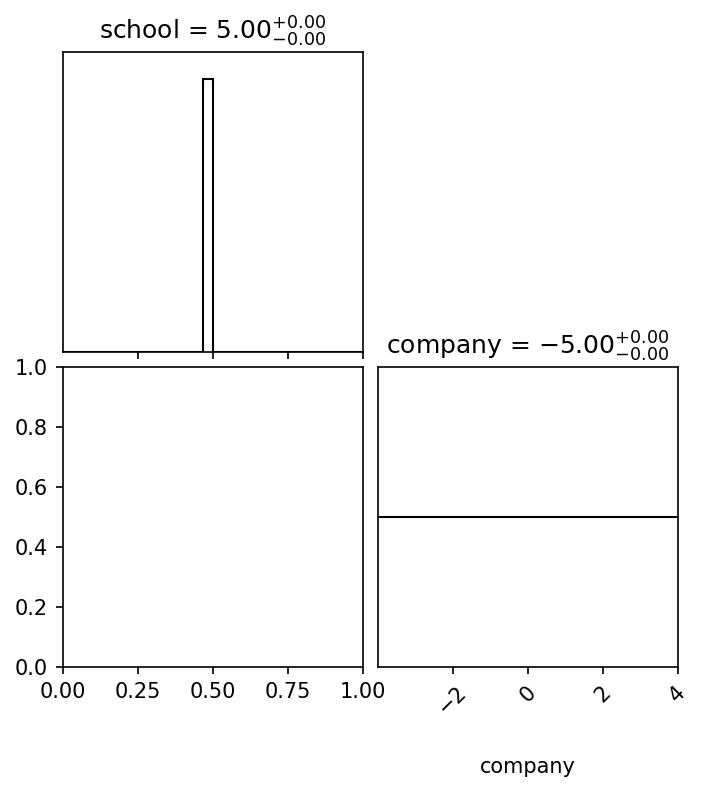

In [8]:
# Train model
max_iter = 250

loss_hist = []
#param_hist = []

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss(reduction="mean")
prior = torch.distributions.Uniform(torch.tensor([-5.,-5.]), torch.tensor([5., 5.]))
im_path = Path("./flow_results")
posteriors_path = im_path / "posteriors"
fits_path = im_path / "fits"

shutil.rmtree(posteriors_path)
posteriors_path.mkdir()
shutil.rmtree(fits_path)
fits_path.mkdir()

best_loss = np.inf

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Sample parameters
    params = prior.sample()
    # run simulator with them
    results = run_for_params(params)
    x = results["cases_per_timestep"]
    score = get_forecast_score(flow, x, n_samples=25)
    #plot_prediction(cases_mean, cases_std, data, it+1)
    #plt.close()
    score.backward()
    optimizer.step()
    loss_hist.append(score.item())
    if score.item() < best_loss:
        torch.save(flow.state_dict(), "./best_model.pth")
        best_loss = score.item()
    plot_posterior(flow, it+1)
    plt.close()
    f, ax = plt.subplots()
    ax.plot(loss_hist)
    ax.set_ylabel("loss")
    ax.set_xlabel("iteration")
    ax.set_yscale("log")
    f.savefig(im_path / "loss.png", dpi=150)
    plt.close()


    # Log loss
loss_hist = np.array(loss_hist)
#param_hist = np.array(param_hist)

In [ ]:
f = flow(data["cases_per_timestep"])

In [ ]:
f.rsample()